<a href="https://colab.research.google.com/github/OnurKerimoglu/Colab_Notebooks/blob/master/Audio_Processing_w_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow_io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.0 MB 1.5 MB/s 


In [2]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import tensorflow_datasets as tfds

(dataset_train_original, dataset_validate_original), info = tfds.load(
    "spoken_digit",
    split = ["train[:80%]", "train[80%:]"],
    as_supervised = True,
    with_info = True
    )
info

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2500 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/spoken_digit/1.0.9.incomplete24BALZ/spoken_digit-train.tfrecord*...:   0%|    …

Dataset spoken_digit downloaded and prepared to ~/tensorflow_datasets/spoken_digit/1.0.9. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='spoken_digit',
    full_name='spoken_digit/1.0.9',
    description="""
    A free audio dataset of spoken digits. Think MNIST for audio.
    
    A simple audio/speech dataset consisting of recordings of spoken digits in wav files at 8kHz.
    The recordings are trimmed so that they have near minimal silence at the beginnings and ends.
    
    5 speakers
    2,500 recordings (50 of each digit per speaker)
    English pronunciations
    
    Files are named in the following format: {digitLabel}_{speakerName}_{index}.wav
    """,
    homepage='https://github.com/Jakobovski/free-spoken-digit-dataset',
    data_path='~/tensorflow_datasets/spoken_digit/1.0.9',
    file_format=tfrecord,
    download_size=11.42 MiB,
    dataset_size=45.68 MiB,
    features=FeaturesDict({
        'audio': Audio(shape=(None,), dtype=tf.int64),
        'audio/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    })

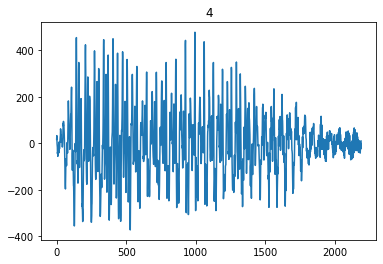

(64, 35)


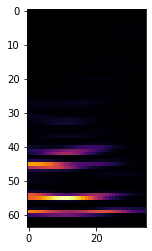

In [17]:
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import librosa
import numpy as np
from IPython.display import display, Audio 

for audio, label in dataset_train_original.shuffle(2500).take(1):
  audio = audio.numpy()
  plt.plot(audio)
  plt.title(f"{label}")
  plt.show()
  plt.close()

  display(Audio(audio,rate=8000))

  mel = librosa.feature.melspectrogram(
      y = audio.astype("float32"),
      n_fft = 2048, # FFT window size (unit: sample size)
      hop_length= 64, # slide step of the FFT window (sample size)  
      n_mels = 64, # number of bins on the frequency axis
      sr = 8000, # sample rate
      fmax = 2000 # this is a low-pass filter
  )
  print(mel.shape)

  plt.imshow(mel[::-1,:], cmap="inferno")

(64, 64, 1)


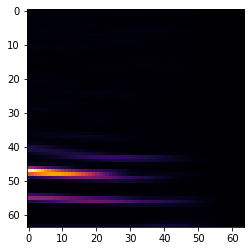

In [34]:
import tensorflow as tf

def preprocess(audio,label):
  audio = tf.cast(audio, tf.float32)/32768.0 #change type (to be able to use GPU) and do some normalization
  
  # Compute spectrogram (frequencies not binned)
  spectrogram = tfio.audio.spectrogram(
      audio, 
      nfft = 1024,
      window = 1024,
      stride = 64
  )
  
  # Mel-spectrogram
  spectrogram = tfio.audio.melscale(
      spectrogram, 
      rate=8000, 
      mels=64, 
      fmin = 0, 
      fmax = 2000 #low-pass filter
  )

  # Normalize
  spectrogram /= tf.math.reduce_max(spectrogram)
  
  # Spectrogram is 2D. Make it 3D, so that we can apply convolution
  spectrogram = tf.expand_dims(spectrogram, axis=-1)

  #Re-adjust the size of the image to make sure all samples are the same size
  spectrogram = tf.image.resize(spectrogram, (64,64))
  # This may speed-up or slow-down, but for the purpose of speech recognition this doesn't matter
  # When speed matters (e.g., music), it would be better to add padding

  # Transpose: just a matter of taste, the convolution doesn't care, 
  # but we just want to see the frequency bins on the x-axis
  spectrogram = tf.transpose(spectrogram, perm=(1,0,2)) #so that the second axis becomes the first axis

  # Flip: again, just a matter of taste: we want the higher frequencies on top, lower at bottom
  spectrogram = spectrogram[::-1,::]

  return spectrogram,label

dataset = dataset_train_original.map(lambda audio, label: preprocess(audio,label))

for x,y in dataset.take(1):
  #plt.plot(x)
  print(x.shape)
  plt.imshow(x.numpy().squeeze(),cmap='inferno')
  plt.show()
  plt.close()

In [37]:
dataset_train = dataset_train_original.map(lambda audio, label: preprocess(audio,label))
dataset_train = dataset_train.cache()
dataset_train = dataset_train.shuffle(2500)
dataset_train = dataset_train.batch(32)

dataset_validate = dataset_validate_original.map(lambda audio, label: preprocess(audio,label))
dataset_validate = dataset_validate.cache()
dataset_validate = dataset_validate.batch(32)

In [39]:
from tensorflow.keras import models,layers

model = models.Sequential()
model.add(layers.Conv2D(8,
                        (3,3), 
                        activation='relu',
                        input_shape=(64,64,1)))
model.add(layers.AveragePooling2D((2,2)))

model.add(layers.Conv2D(16,(3,3), activation='relu',))
model.add(layers.AveragePooling2D((2,2)))

model.add(layers.Conv2D(32,(3,3), activation='relu',))
model.add(layers.AveragePooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 8)         80        
                                                                 
 average_pooling2d_3 (Averag  (None, 31, 31, 8)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 16)        1168      
                                                                 
 average_pooling2d_4 (Averag  (None, 14, 14, 16)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 32)        4640      
                                                                 
 average_pooling2d_5 (Averag  (None, 6, 6, 32)        

In [41]:
model.compile(
    optimizer = "adam",
    #loss = "categorical_crossentropy" #this would require one-hot encoding of the labels
    loss = "sparse_categorical_crossentropy", #this doesn't require it
    metrics = "accuracy"
)

history = model.fit(
    dataset_train,
    epochs=50,
    validation_data = dataset_validate
)

Epoch 1/50
63/63 [==============================] - 12s 103ms/step - loss: 1.5579 - accuracy: 0.5075 - val_loss: 0.7810 - val_accuracy: 0.7340
Epoch 2/50
63/63 [==============================] - 4s 71ms/step - loss: 0.6347 - accuracy: 0.7740 - val_loss: 0.5624 - val_accuracy: 0.8040
Epoch 3/50
63/63 [==============================] - 6s 96ms/step - loss: 0.4640 - accuracy: 0.8555 - val_loss: 0.5238 - val_accuracy: 0.8400
Epoch 4/50
63/63 [==============================] - 5s 77ms/step - loss: 0.4014 - accuracy: 0.8685 - val_loss: 0.4185 - val_accuracy: 0.8680
Epoch 5/50
63/63 [==============================] - 5s 72ms/step - loss: 0.3054 - accuracy: 0.9035 - val_loss: 0.3919 - val_accuracy: 0.8980
Epoch 6/50
63/63 [==============================] - 5s 73ms/step - loss: 0.2742 - accuracy: 0.9100 - val_loss: 0.3957 - val_accuracy: 0.8700
Epoch 7/50
63/63 [==============================] - 5s 73ms/step - loss: 0.2147 - accuracy: 0.9325 - val_loss: 0.3263 - val_accuracy: 0.9120
Epoch 8/50
